In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
lr = 1e-3
epoch = 10
batch_size = 100

In [3]:
import tensorflow as tf
import numpy as np
import copy
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 28, 28, 1)), x_test.reshape((-1, 28, 28, 1))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = copy.copy(y_train).astype(np.int32) 
y_test_cls = copy.copy(y_test).astype(np.int32)
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(y_train_cls.shape, y_test_cls.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 10) (10000, 10)
(60000,) (10000,)


In [4]:
x = tf.placeholder(tf.float32, (None,28, 28, 1)) # (?, 28, 28, 1)
y = tf.placeholder(tf.float32, (None,10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)
dropout_rate = tf.placeholder(tf.float32, shape=[], name='dropout_rate')

initializer_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

w1 = tf.get_variable("w1", [5, 5, 1, 32], tf.float32, initializer_w)  
y1 = tf.nn.conv2d(input=x, filter=w1, strides=[1, 1, 1, 1], padding='SAME')
y1 = tf.nn.max_pool(value=y1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y1 = tf.nn.relu(y1)

w2 = tf.get_variable("w2", [5, 5, 32, 64], tf.float32, initializer_w)  
y2 = tf.nn.conv2d(input=y1, filter=w2, strides=[1, 1, 1, 1], padding='SAME')
y2 = tf.nn.max_pool(value=y2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y2 = tf.nn.relu(y2) 
y2 = tf.reshape(y2, [-1, 3136])

w3 = tf.get_variable("w3", [3136, 100], tf.float32, initializer_w)
y3 = tf.nn.relu(y2@w3) 
y3 = tf.nn.dropout(y3, rate=dropout_rate)

w4 = tf.get_variable("w4", [100, 10], tf.float32, initializer_w)
logits = tf.identity(y3@w4, name='logits')
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()
print(logits.shape, entropy.shape, loss.shape)

train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), name='accuracy') # () float32
print(y_pred_cls.shape, correct_bool.shape, accuracy.shape)
print(y_pred_cls.dtype, correct_bool.dtype, accuracy.dtype)

(?, 10) (?,) ()
(?,) (?,) ()
<dtype: 'int32'> <dtype: 'bool'> <dtype: 'float32'>


In [5]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        for k in range(x_train.shape[0]//batch_size):
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch, dropout_rate: 0.3}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls, dropout_rate: 0.0}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)

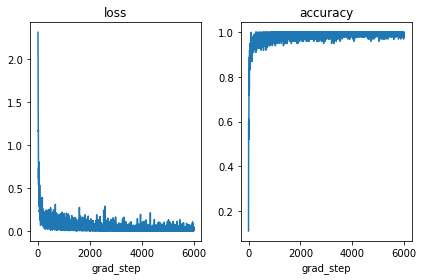

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [7]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.993


In [8]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 976    1    0    0    0    0    2    1    0    0]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   0    1 1029    0    0    0    0    1    1    0]
 [   0    0    3 1005    0    1    0    0    1    0]
 [   0    0    0    0  977    0    1    0    0    4]
 [   1    0    1    5    0  882    2    0    0    1]
 [   2    2    0    0    1    0  952    0    1    0]
 [   0    4    8    0    0    0    0 1012    1    3]
 [   3    0    1    0    0    0    0    0  968    2]
 [   0    0    2    0    5    0    0    4    1  997]]


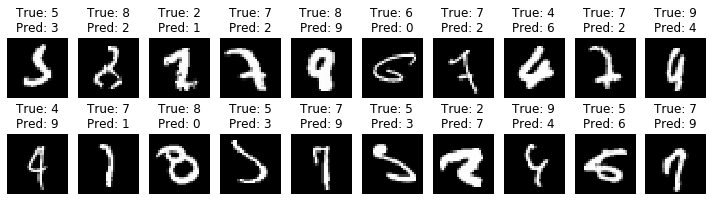

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test_cls[idx], y_test_cls_pred[idx]))
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()

Let $X_i$ be iid with mean $\mu$. Then
$$
E\sum_{i=1}^nX_i=n\mu
$$
If we flip a coin with success rate $p=1-\mbox{dropout_rate}$ independently,
and if we drop those $X_i$ with tails,
then
$$
E\sum_{i=1}^nX_i1(\mbox{$i$-th flip is head})=np\mu=n(1-\mbox{dropout_rate})\mu
$$
So, to keep expectation stay identical after dropout
we have to scale up by a factor $\frac{1}{1-\mbox{dropout_rate}}$.
$$
E\sum_{i=1}^n\frac{X_i1(\mbox{$i$-th flip is head})}{1-\mbox{dropout_rate}}=n\mu
$$